# Projeto final do curso de Machine Learning da ADA


## Premissa


Como forma de avaliação e validação dos conhecimento adquiridos durante o módulo "*Machine Lerning I*" no curso de *Data Science* ministrado pelo professor [Thiago Tavares Magalhães](https://www.linkedin.com/in/thiagotm/), na instituição [**Ada Tech**](https://ada.tech/), foi proposto um trabalho final que utilize os conhecimentos demonstrados e adquiridos durante a execução do curso.

O trabalho consiste em escolher um dataset de domínio publico e aplicar as ferramentas aprendidas em aula, de forma a obter, um modelo de aprendizado de máquina, capaz de categorizar e generalizar respostas em consistencia com o banco de dados no qual foi utilizado para o seu treinamento.

## Alunos/Autores

Os alunos que desenvolveram o trabalho foram:
- [Alexandre Paulino](https://www.linkedin.com/in/alexandre-e-paulino/)
- [Carolina Rutili de Lima](https://www.linkedin.com/in/carolinarutili/)
- [Raphael Giffoni Vieira Silva](https://www.linkedin.com/in/raphael-giffoni-b9a386172/)
- [Hugo Cezar Sales de Souza](https://www.linkedin.com/in/hugo-cs-souza/)
- [Lucas Meirelles](https://www.linkedin.com/in/lucas-meirelles-a758a5a4/)


## Escolha do Dataset

Escolhemos o [seguinte dataset](https://www.kaggle.com/datasets/tavarez/the-orl-database-for-training-and-testing) que consiste em imagens de pessoas para classificação.

O Banco de Dados ORL de Rostos é um conjunto de imagens faciais tiradas entre abril de 1992 e abril de 1994 no laboratório. O banco de dados foi usado no contexto de um projeto de reconhecimento facial realizado em colaboração com o Grupo de Fala, Visão e Robótica do Departamento de Engenharia da Universidade de Cambridge.

Há dez imagens diferentes de cada um dos 40 sujeitos distintos. Para alguns sujeitos, as imagens foram tiradas em diferentes momentos, variando a iluminação, expressões faciais (olhos abertos/fechados, sorrindo/não sorrindo) e detalhes faciais (óculos/sem óculos). Todas as imagens foram tiradas contra um fundo escuro homogêneo com os sujeitos em posição frontal e ereta (com tolerância para algum movimento lateral).

## Objetivo

O objetivo deste trabalho é utilizar este dataset, para classificar, através das imagens, o sexo biológico da pessoa da imagem em questão. O dataset está dividas em imagens de 20 homens e 20 mulheres no dataset.

## Desenvolvimento


### Ferramentas utilizadas

As ferramentas/conhecimentos utilizados no desenvolvimento deste trabalho serão:
- Utilização do Scikit-learn
- KNNs
- Random Forests
- Métricas de Avaliação de Modelos de Classificação
- Otimização de hiperparâmetros

### Explicação da manipulação do dataset

Existem 400 imagens de rostos dentro do dataset. Cada imagem tem dimensão de 46 pixels × 56 pixels. Cada pessoa tem 10 imagens distintas dentro do dataset.

A forma de categorizar e individualizar as 400 imagens será, transformar cada pixel em uma coluna para que possam ser comparados, onde o valor do pixel na escala de cinza será armazenado como uma variável quantitativa. Sendo assim, teremos uma matriz de dados de 400 linhas × 2576 colunas, onde cada linha representa uma das imagens. Posterior a esta manipulação, será criada uma coluna adicional de rótulos indicando o gênero biológica da pessoa que está apresentada na foto, por exemplo, "0" = feminino, "1" = masculino.


### Execução do código

#### Inicialização e verificação das variáveis essenciais para o modelo

##### Importação das bibliotecas

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from PIL import Image
import statsmodels.api as sm
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

##### Criação da coluna de gêneros

In [2]:
# Criada uma matriz correspondentes ao gêneros de cada imagem
gender = [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]
# Para cada gênero, como tem 10 imagens, repete 10 vezes para gerar a coluna corretamente
final = []
for i in gender:
  if i == 0:
    for j in range(0,10):
      final.append(0)
    #new_list = [0,0,0,0,0,0,0,0,0,0]
  else:
    for j in range(0,10):
      final.append(1)
# Transforma a lista de gêneros em um array do numpy
gender = np.asarray(final)
gender = np.expand_dims(gender, axis=1)
gender.shape


(400, 1)

##### Função para carregamento das imagens

In [3]:
# Indicar o caminho relativo da pasta do dataset
folder = './images/'  # Updated folder path
# Função para carregar as imagens para o ambiente
def load_images_from_folder(folder):
  i = 1
  # Gera uma lista dos caminhos das imagens e itera sobre eles
  for filename in os.listdir(folder):
    # Abre a imagem, transforma num array, reduz para uma dimensão e expande no eixo x
    im = Image.open(os.path.join(folder,filename))
    data = np.array(im)
    flattened = data.flatten()
    reshape_fla = np.expand_dims(flattened, axis=0)
    if i == 1:
      final = reshape_fla
      i = 2
    else:
      final = np.vstack((final,reshape_fla))
  return final

pixels = load_images_from_folder(folder)
pixels.shape

(400, 5600)

##### Rotulando os dados e realizando a regressão

In [4]:
# Atribui o genero como categorização de saída
x, y = pixels, gender

x_reg = sm.add_constant(x)
model = sm.OLS(y,x_reg)
results = model.fit()
results.params

array([2.15568857e-06, 4.83164692e-05, 2.07274421e-05, ...,
       3.25743479e-05, 1.16551400e-04, 8.61888666e-05])

##### Encontrando o melhor pixel através do p-value

In [5]:
best_p = float('inf')
best_pixel = None

# Transpondo a matriz para melhor acessar as colunas
X_transposed = x.T

for j in range(len(X_transposed)):
    Xs = sm.add_constant(X_transposed[j])  # Adiciona uma coluna de 1s na matriz
    model = sm.OLS(y, Xs) #Realiza uma regressão linear
    results = model.fit() #Treina o modelo
    p_value = results.pvalues[1]  # Pega o p-value do pixel 

    if p_value < best_p:
        best_p = p_value
        best_pixel = j

print(f"Best Pixel: {best_pixel}, Best P-Value: {best_p}")

Best Pixel: 1824, Best P-Value: 1.6131875247093263e-06


##### Entrando o p-value do primeiro pixel


In [6]:
Xs, pvalues = [], []

for j in range(0,len(x)):
  for i in range(0,len(y)):
    Xs.append(x[i][j]) 
  Xs = sm.add_constant(Xs)
  model_2 = sm.OLS(y,Xs)
  results_each = model_2.fit()
  p_values = results_each.pvalues
  pvalues.append(p_values[1])
  Xs=[]

##### Encontrando os três melhores pixels através do p-value

In [7]:
MAX = float('inf')
def Print3Smallest(arr, n):
    firstmin = MAX
    secmin = MAX
    thirdmin = MAX
 
    for i in range(0, n):
        if arr[i] < firstmin:
            thirdmin = secmin
            secmin = firstmin
            firstmin = arr[i]
            first = i
        elif arr[i] < secmin:
            thirdmin = secmin
            secmin = arr[i]
            second = i
        elif arr[i] < thirdmin:
            thirdmin = arr[i]
            third = i
    print("First pixel = ", firstmin, "position = ", first)
    print("Second pixel = ", secmin, "position = ", second)
    print("Third pixel = ", thirdmin, "position = ", third)
    return first, second, third

n = len(pvalues)
first, second, third = Print3Smallest(pvalues, n)
pixels =  [first, second, third]


First pixel =  0.04054828430444952 position =  364
Second pixel =  0.04354810419281873 position =  365
Third pixel =  0.04792225319327901 position =  68


##### Encontrando a posição do pixel na imagem

In [8]:
x_pos = []
y_pos = []
width = 46

for pixel in pixels:
  y_posi = pixel//width 
  x_posi = (pixel - (width*y_posi)) + 1 
  x_pos.append(x_posi)
  y_pos.append(y_posi)

x_pos.append(46)
y_pos.append(56)

##### Pixels mais importantes para a classificação

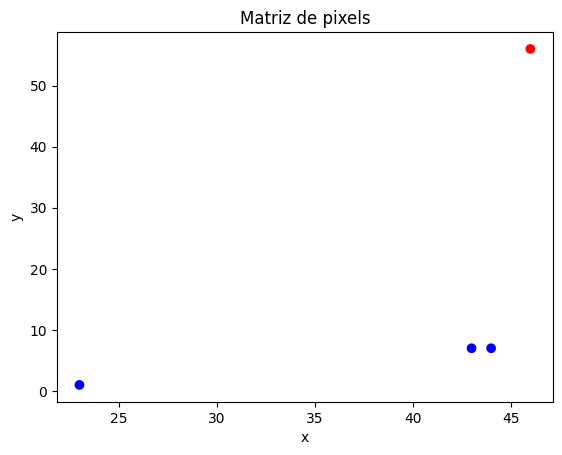

In [9]:
colors=["b", "b", "b", "r"]
plt.scatter(x_pos,y_pos, c=colors)
plt.title('Matriz de pixels')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Execução de diferentes modelos de regressão e generalização

##### Regressão Linear utilizando Lasso

c:\Users\Nugrinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.136e-02, tolerance: 3.600e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\Nugrinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.671e-01, tolerance: 3.600e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\Nugrinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

Menor erro quadrático (Lasso): 0.09000000000000005
Alpha com o menor valor de erro (Lasso): 0.07121


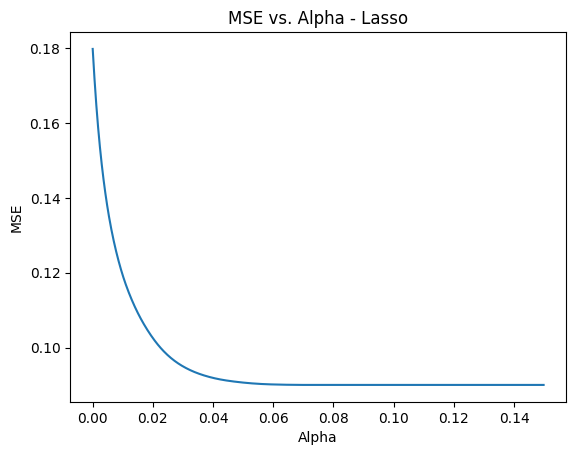

In [10]:
# Normaliza os dados utilizados o modelo de padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)  
MSE, alphas = [], []

#Modifica o peso do coefiente angular
for i in range(1, 15000, 20):
    alpha = i / 100000
    lasso = Lasso(alpha=alpha) 
    lasso.fit(X_scaled, y) 
    # Calcula o erro quadrático médio
    MSE.append(np.mean((lasso.predict(X_scaled) - y) ** 2))
    alphas.append(alpha)

# Encontra o melhor coeficiente e o menor minimo
min_mse = min(MSE)
index_alpha = MSE.index(min_mse)
best_alpha_lasso = alphas[index_alpha]

print("Menor erro quadrático (Lasso):", min_mse)
print("Alpha com o menor valor de erro (Lasso):", best_alpha_lasso)

# Plote
plt.title("MSE vs. Alpha - Lasso")
plt.xlabel("Alpha")
plt.ylabel("MSE")
plt.plot(alphas, MSE)
plt.show()


##### Regressão linear utilizando Rigde

Menor erro quadrático (Ridge): 4.4880566445811915e-17
Alpha com o menor valor de erro (Ridge): 1e-05


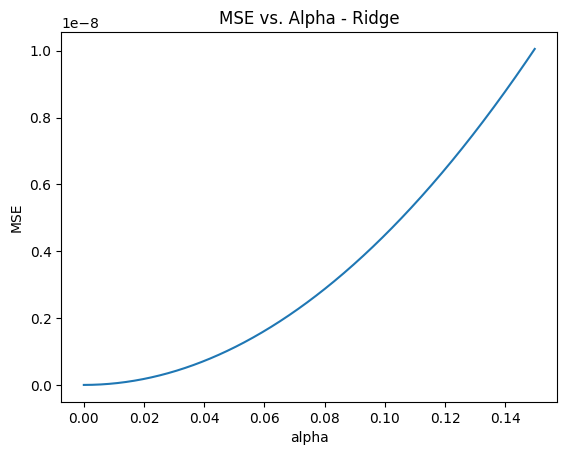

In [11]:
# Normaliza os dados utilizados o modelo de padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
MSE, alphas = [], []

for i in range(1, 15000, 20):
    alpha = i / 100000
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_scaled, y) 
    MSE.append(np.mean((ridge.predict(X_scaled) - y) ** 2))
    alphas.append(alpha)

# Finding the minimum MSE and corresponding alpha
min_mse = min(MSE)
index_alpha = MSE.index(min_mse)
best_alpha_ridge = alphas[index_alpha]

print("Menor erro quadrático (Ridge):", min_mse)
print("Alpha com o menor valor de erro (Ridge):", best_alpha_ridge)

# Plotting the MSE vs alpha
plt.title("MSE vs. Alpha - Ridge")
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.plot(alphas, MSE)
plt.show()

##### Calculando a média do erro quadrático

In [12]:
X_reg = sm.add_constant(x)
model = sm.OLS(y,X_reg)
results = model.fit()
MRS = np.mean((results.predict(X_reg) - y) ** 2)

print("Erro médio: ", MRS)

Erro médio:  0.1800000000000001


##### Separando os datasets em treino e teste

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

##### Regressão Logística


In [14]:
LR = LogisticRegression()
LR.fit(X_train, y_train)
predictions_LR = LR.predict(X_test)
print("LR preductions: ", predictions_LR)
print("LR accuracy: ", 100*LR.score(X_test, y_test),"%")

LR preductions:  [1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1]
LR accuracy:  93.75 %


c:\Users\Nugrinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##### K-Nearest Neighbor

c:\Users\Nugrinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Nugrinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Nugrinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Nugrinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neighbors\_classificat

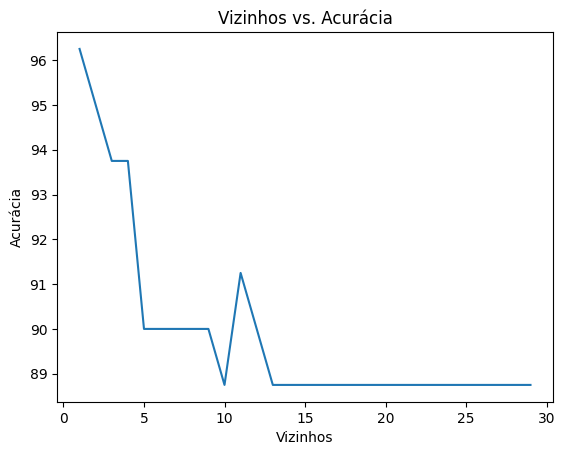

In [15]:
neighbor, accuracy = [], []
for k in range(1,30):
    KNN = KNeighborsClassifier(n_neighbors = k)
    KNN.fit(X_train,y_train)
    predictions_KNN = KNN.predict(X_test)
    neighbor.append(k)
    accuracy.append(100*KNN.score(X_test, y_test))

# Plot
plt.title("Vizinhos vs. Acurácia")
plt.xlabel("Vizinhos")
plt.ylabel("Acurácia")
plt.plot(neighbor, accuracy)
plt.show()

##### Support Vector Machine - Sigmoid

In [16]:
SVM = svm.SVC(kernel='sigmoid',C=1)
SVM.fit(X_train,y_train)
predictions_SVM = SVM.predict(X_test)
print("SVM preductions: ", predictions_SVM)
print(" SVM accuracy model: ",100*SVM.score(X_test, y_test),"%")

SVM preductions:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
 SVM accuracy model:  88.75 %


c:\Users\Nugrinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##### Support Vector Machine - Linear

In [17]:
SVM = svm.SVC(kernel='linear',C=1)
SVM.fit(X_train,y_train)
predictions_SVM = SVM.predict(X_test)
print("SVM preductions: ", predictions_SVM)
print("SVM accuracy model: ",100*SVM.score(X_test, y_test),"%")

c:\Users\Nugrinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM preductions:  [1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1]
SVM accuracy model:  96.25 %


##### Modelo de classificador de Bayes

c:\Users\Nugrinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: >

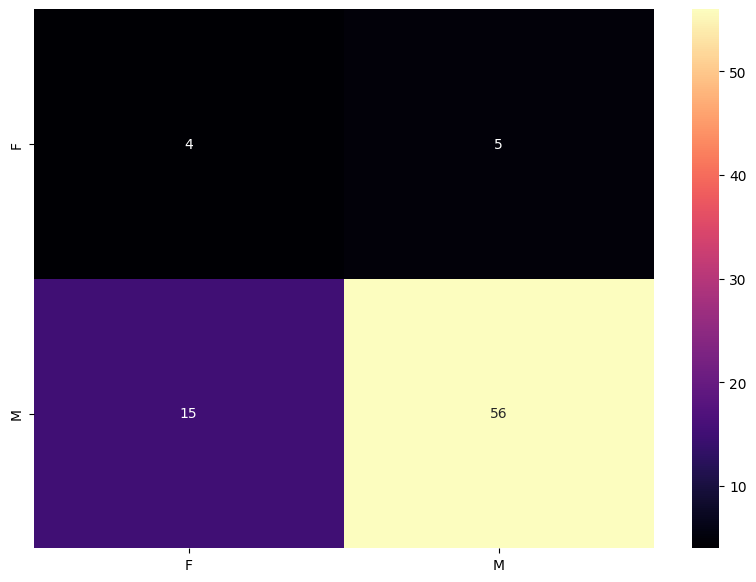

In [18]:
# Criando o modelo
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

# Geração de previões
previsoes = naive_bayes.predict(X_test)
previsoes

#Matriz de confusão
confusao = confusion_matrix(y_test, previsoes)
confusao

# Calculando a taxa de acerto e de erro
taxa_acerto = accuracy_score(y_test, previsoes)
taxa_erro = 1 - taxa_acerto
taxa_acerto


matrix_confusion = pd.DataFrame(confusao, index = ["F","M"], columns = ["F","M"])
plt.figure(figsize = (10,7))
sn.heatmap(matrix_confusion, annot=True, cmap='magma')

##### Árvores de decisão

A acurácia do método foi: 85.00%


<Axes: >

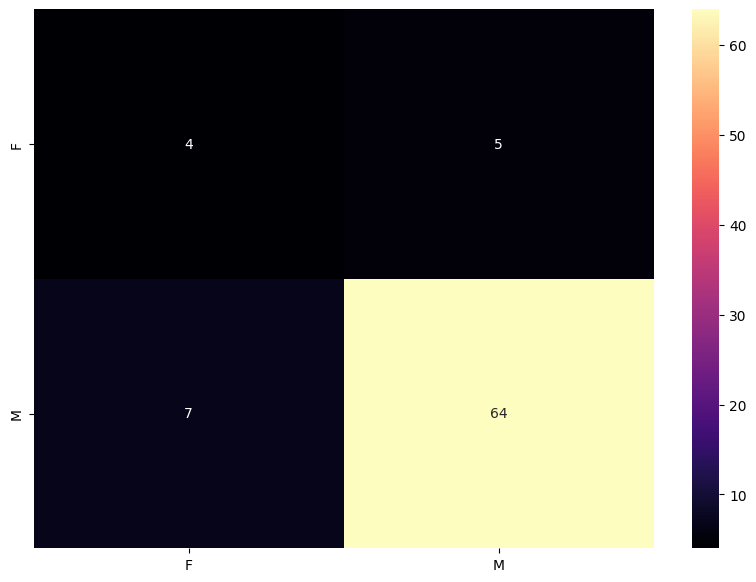

In [19]:
# Criação do modelo
arvore = DecisionTreeClassifier()

# Treinamento do modelo
arvore.fit(X_train, y_train)

# Obtendo as previsões
previsoes = arvore.predict(X_test)
previsoes

# Confusion Matrix
confusao = confusion_matrix(y_test, previsoes)
confusao

# Calculando a taxa de acerto
taxa_acerto = accuracy_score(y_test, previsoes)
taxa_acerto

# Calculando a taxa de erro
taxa_erro = 1 - taxa_acerto
print(f"A acurácia do método foi: {taxa_acerto:.2%}")

matrix_confusion = pd.DataFrame(confusao, index = ["F","M"], columns = ["F","M"])
plt.figure(figsize = (10,7))
sn.heatmap(matrix_confusion, annot=True, cmap='magma')

#### Melhoramento dos modelos com otimização dos hiperparâmetros

##### Árvore de decisão sem otimização

In [20]:
# Treinando o modelo decision_tree
dec_tree_def_clf = DecisionTreeClassifier()
dec_tree_def_clf.fit(X_train, y_train)

# Predizendo saídas para o dataset de treinamento
y_train_pred = dec_tree_def_clf.predict(X_train)

# Predizendo saídas para o dataset de testes
y_test_pred = dec_tree_def_clf.predict(X_test)

# Calculando AUC em treinamento e em teste
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

print(f"AUC_train = {roc_auc_train}, AUC_tes = {roc_auc_test}")

AUC_train = 1.0, AUC_tes = 0.6244131455399061


##### Árvores de decisão com hiperparâmetros otimizados via grid-search

In [21]:
# Definindo o grid de parâmetros a serem testados
param_grid = {
  'criterion': ['gini', 'entropy'],
  'max_depth': [None, 5, 10, 15],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
  estimator = DecisionTreeClassifier(),
  param_grid = param_grid,
  cv = 5
)

# Ajustando o GridSearch ao conjunto de treinamento
grid_search.fit(X_train, y_train)

# Obtendo os melhores parâmetros encontrados
dec_tree_gs_best_params = grid_search.best_params_
print(dec_tree_gs_best_params)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [22]:
# Treinando o modelo
dec_tree_gs_clf = DecisionTreeClassifier(**dec_tree_gs_best_params)
dec_tree_gs_clf.fit(X_train, y_train)

# Predizendo saídas para o dataset de treinamento
y_train_pred = dec_tree_gs_clf.predict(X_train)

# Predizendo saídas para o dataset de testes
y_test_pred = dec_tree_gs_clf.predict(X_test)

# Calculando AUC em treinamento e em teste
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

print(f"AUC_train = {roc_auc_train}, AUC_tes = {roc_auc_test}")

AUC_train = 0.9014957026453845, AUC_tes = 0.5344287949921752


##### Árvores de decisão com hiperparâmetros otimizados via random-search

In [23]:
# Definindo o espaço de busca para os hiperparâmetros
param_dist = {
  'criterion': ['gini', 'entropy'],
  'max_depth': randint(1, 20),
  'min_samples_split': randint(2, 20),
  'min_samples_leaf': randint(1, 10)
}

random_search = RandomizedSearchCV(
  estimator = DecisionTreeClassifier(),
  param_distributions = param_dist,
  n_iter = 200,
  cv = 5
)

# Ajustando a pesquisa aleatória ao conjunto de treinamento
random_search.fit(X_train, y_train)

# Obtendo os melhores parâmetros encontrados
dec_tree_rs_best_params = random_search.best_params_
print(dec_tree_rs_best_params)

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 7}


In [24]:
# Treinando o modelo
dec_tree_rs_clf = DecisionTreeClassifier(**dec_tree_rs_best_params)
dec_tree_rs_clf.fit(X_train, y_train)

# Predizendo saídas para o dataset de treinamento
y_train_pred = dec_tree_rs_clf.predict(X_train)

# Predizendo saídas para o dataset de testes
y_test_pred = dec_tree_rs_clf.predict(X_test)

# Calculando AUC em treinamento e em teste
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

print(f"AUC_train = {roc_auc_train}, AUC_tes = {roc_auc_test}")

AUC_train = 0.7563344123228039, AUC_tes = 0.6040688575899844


##### Floresta aleatória 

In [25]:
# Treinando o modelo
rforest_rs_clf = RandomForestClassifier()
rforest_rs_clf.fit(X_train, y_train)

# Predizendo saídas para o dataset de treinamento
y_train_pred = rforest_rs_clf.predict(X_train)

# Predizendo saídas para o dataset de testes
y_test_pred = rforest_rs_clf.predict(X_test)

# Calculando AUC em treinamento e em teste
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

print(f"AUC_train = {roc_auc_train}, AUC_tes = {roc_auc_test}")

c:\Users\Nugrinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


AUC_train = 1.0, AUC_tes = 0.6111111111111112


##### Floresta aleatória  com hiperparâmetros otimizados via random-search

In [26]:
# Definindo o espaço de busca para os hiperparâmetros
param_dist = {
    'n_estimators': randint(10, 200),
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(randint(1, 20).rvs(5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
  estimator=RandomForestClassifier(),
  param_distributions=param_dist,
  n_iter=200,
  cv=5,
  random_state=42
)

# Ajustando a pesquisa aleatória ao conjunto de treinamento
random_search.fit(X_train, y_train)

# Obtendo os melhores parâmetros encontrados
rforest_rs_best_params = random_search.best_params_
print(rforest_rs_best_params)

c:\Users\Nugrinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Nugrinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Nugrinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Nugrinho\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474:

In [ ]:
# Treinando o modelo
rforest_rs_clf = RandomForestClassifier(**rforest_rs_best_params)
rforest_rs_clf.fit(X_train, y_train)

# Predizendo saídas para o dataset de treinamento
y_train_pred = rforest_rs_clf.predict(X_train)

# Predizendo saídas para o dataset de testes
y_test_pred = rforest_rs_clf.predict(X_test)

# Calculando AUC em treinamento e em teste
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

print(f"AUC_train = {roc_auc_train}, AUC_tes = {roc_auc_test}")

### KNN Padrão

In [ ]:
# Treinando o modelo
knn_rs_clf = KNeighborsClassifier()
knn_rs_clf.fit(X_train, y_train)

# Predizendo saídas para o dataset de treinamento
y_train_pred = knn_rs_clf.predict(X_train)

# Predizendo saídas para o dataset de testes
y_test_pred = knn_rs_clf.predict(X_test)

# Calculando AUC em treinamento e em teste
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

print(f"AUC_train = {roc_auc_train}, AUC_tes = {roc_auc_test}")

##### KNN com hiperparâmetros otimizados via random-search

In [ ]:
# Definindo o espaço de busca para os hiperparâmetros
param_dist = {
    'n_neighbors': randint(1, 50),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # para a distância de Minkowski (1 para Manhattan, 2 para Euclidiana)
}

random_search = RandomizedSearchCV(
  estimator = KNeighborsClassifier(),
  param_distributions = param_dist,
  n_iter = 200,
  cv = 5
)

# Ajustando a pesquisa aleatória ao conjunto de treinamento
random_search.fit(X_train, y_train)

# Obtendo os melhores parâmetros encontrados
knn_rs_best_params = random_search.best_params_
print(knn_rs_best_params)

In [ ]:
# Treinando o modelo
knn_rs_clf = KNeighborsClassifier(**knn_rs_best_params)
knn_rs_clf.fit(X_train, y_train)

# Predizendo saídas para o dataset de treinamento
y_train_pred = knn_rs_clf.predict(X_train)

# Predizendo saídas para o dataset de testes
y_test_pred = knn_rs_clf.predict(X_test)

# Calculando AUC em treinamento e em teste
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

print(f"AUC_train = {roc_auc_train}, AUC_tes = {roc_auc_test}")

##### Cross-validation com Pipelines



In [ ]:
# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Criando pipeline para pré-processamento e classificação
pipeline = Pipeline([
    ('classifier', DecisionTreeClassifier())
])

# Treinando o modelo e avaliando usando cross-validation
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

# Ajustando o modelo final usando todos os dados de treinamento
pipeline.fit(X_train, y_train)

# Avaliando o modelo no conjunto de teste
roc_auc_test = roc_auc_score(y_test, pipeline.predict(X_test))

print(f"AUC_train (CV) = {scores.mean()}, AUC_test = {roc_auc_test}")

##### Cross-validation com Pipelines incluindo random search

In [ ]:
# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Criando pipeline para pré-processamento e classificação
pipeline = Pipeline([
    ('classifier', DecisionTreeClassifier())
])

# Definindo o espaço de busca de hiperparâmetros
param_dist = {
    'classifier__max_depth': randint(1, 20),  # Profundidade máxima da árvore
    'classifier__min_samples_split': randint(2, 20),  # Número mínimo de amostras necessárias para dividir um nó interno
    'classifier__min_samples_leaf': randint(1, 20),  # Número mínimo de amostras necessárias para estar em um nó folha
}

# Criando o objeto RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy')

# Executando a busca aleatória de hiperparâmetros
random_search.fit(X_train, y_train)

# Melhores hiperparâmetros encontrados
best_params = random_search.best_params_

# Melhor estimador encontrado
best_estimator = random_search.best_estimator_

# Avaliando o modelo no conjunto de teste usando os melhores hiperparâmetros encontrados
roc_auc_test = roc_auc_score(y_test, best_estimator.predict(X_test))

print(f"Best parameters: {best_params}")
print(f"AUC_train (CV) = {random_search.best_score_}, AUC_test = {roc_auc_test}")

### Conclusões


Ao analisar o dataset, vemos que o número de mulheres é mínimo para este conjunto de dados, e o algoritmo de aprendizado de máquina não consegue aprender quando se trata de uma mulher. Podemos dizer que ele é tendencioso, e deveríamos treinar com um conjunto de dados mais diversificado.

Mesmo assim, ao realizar os treinamentos, vemos que por se tratar de uma dataset desbalanceado, quais todos os modelos apresentado comportamento de *overfitting*, ou seja, os modelos se comportam muito bem sobre os dados de treinamento, conseguindo categorizar exatamente os dados de treinamento em alguns casos, mas ao se colocar os dados de teste, a capacidade de categorizar dos modelos caem vertiginosamente.

Para tentar melhorar os resultados, métodos de otimizar os hiperparâmetros foram realizados. Porém, como já se é de imaginar, não foi possivel melhorar exponencialmente o resultado dos modelos, visto que temos uma limitação associada a má distribuição do dataset. Porém, estas conclusões só foram possíveis através do compreendimento dos conhecimentos apresentados em aula, associando o estudo do dataset (**EDA**) as limitações apresentadas nos resultados. 

Ainda sim, todos os métodos foram corretamente aplicados e apresentados, podendo ser generalizados a outros datasets.

### Referências

- [Dataset]((https://www.kaggle.com/datasets/tavarez/the-orl-database-for-training-and-testing) )
- [Repositório do projeto](https://github.com/carolinarutililima/Final_Project_Machine_Learning_I)
- [Scikit Learn](https://scikit-learn.org/stable/index.html)
- [Pandas](https://pandas.pydata.org/)
- [Seaborn](https://seaborn.pydata.org/index.html)
- [Pillow](https://pillow.readthedocs.io/en/stable/#)
- [NumPy](https://numpy.org/)
- [MatPlotLib](https://matplotlib.org/)
- [Ada Tecnologia e Educação S.A.](https://ada.tech/)